## Module Walkthrough

### Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np

In [ ]:
treatments = pd.read_csv('treatments.csv')
treatments

In [ ]:
# treatmenta, treatmentb, and treatmentc are all variables, and thus have their
# own columns.  HOWEVER, the numbers in the columns represent each patient's 
# response to that treatment.  Eg: John Smith did not take treatmenta, but 
# had a 2 response to treatmentb and a 0 response to treatmentc.

# Jane Doe had a 16.0 response to treatmenta, a 1 to treatmentb, and a 3 to 
# treatmentc.  MaryJo had a 3 to treatmenta, a 1 to b, and a 4 to c.

#### Make the subject's responses their own columns by:

- a. renaming the columns so that they're easier to read

- b. apply a melt to combine the last three columns

In [ ]:
# rename the columns
treatments.columns = ["name", "a", "b", "c"]
treatments

In [ ]:
# apply the melt (do NOT melt id_vars (the 'name' column here)).  
# 'var_name' is the name of the column that will hold the name of the combined columns
# 'val_name' the name of the column that will hold the resulting values

treatments.melt(id_vars=["name"], var_name="treatment", value_name="response")

### One Column with Multiple Variables

#### Pull the 'students' csv for work

In [ ]:
students = pd.read_csv("students.csv")
students.head()

#### The above df had a melt incorretly applied to it.  Unmelt it:

- we want A, B, C, and D to be separate columns

- note the 'var' has several different variables

- note the 'val' column has the values corresponding with each of them.

- We'd be better off making separate columns for 'n_late_from_break,' 'coffee_consumption,' and 'classroom_temp' b/c they are all independent from each other

#### To unmelt, make a pivot table:

In [ ]:
students.pivot(index="date", columns="var").head()

# here, we change the index to date:

In [ ]:
students.set_index(["date", "var"]).unstack(level=1).head()

# Doing this (the .set_index thing) tells pandas to create a MultiIndex.  

# A MultiIndex takes two (or more) columns and makes an index out of them.

#### For our case, though, we don't need a MultiIndex, so now we have to drop it in order to make the df easier to work with.

In [ ]:
# Step 1:
tidy_students = students.set_index(["date", "var"]).unstack(level=1)
tidy_students.head()

In [ ]:
# Step 2:
tidy_students.columns = tidy_students.columns.droplevel()
tidy_students.columns

In [ ]:
# Step 3: I have to have that level from the ValueError in there:

tidy_students.columns.name = ""
tidy_students.head()

#### Notice that the 'val' and 'var' values are dropped, and our df looks a lot cleaner

### Now for a more complex example that needs more tidying

In [ ]:
sales = pd.read_csv("sales.csv")
sales.head()

#### Above, we see column names that combine a year and a variable.  Ew.

#### What we need to do is tidy it up so that it looks nice and easy to read.

In [ ]:
# Step 1: melt in a way that combines the columns together:

sales_melt = sales.melt(id_vars="Product", var_name="year_and_measure")
sales_melt.head(10)

#### Above, we've 'melted' seven columns down to three.  At quick glance, you can see 673 units of Product A were moved in 2016, and 231 units of Product A were moved in 2017.  Same product, but a lot less moved in 2017 than in 2016

#### Now we need to split 'year_and_measure' into two columns: 'year' and 'measure.'

In [ ]:
year_and_measure_df = sales_melt.year_and_measure.str.split(" ", expand=True)
year_and_and_measure_df

In [ ]:
# Continuing after having read the error and not correcting in the preceding cell
# so I could better figure out what's going on:

year_and_measure_df.columns = ["year", "measure"]
year_and_measure_df.head(10)

#### AHA!  We have see those two columns are now a pd Series, which can be attached to the original dataframe:

In [ ]:
sales2 = pd.concat([sales_melt, year_and_measure_df], axis=1).drop(columns="year_and_measure")
sales2.head()

In [ ]:
sales_tidy = sales2.pivot_table(index=["Product", "year"], columns="measure", values="value")
sales_tidy.head()

#### That df above is back to looking crazy again, even after all our changes.  Time to make it easier to read again:

In [ ]:
sales_tidy.columns.name = ""
sales_tidy.reset_index(inplace=True)
sales_tidy

### AND NOW... The Exercises:

### Q1: Attendance Data

Load the attendance.csv file and calculate an attendnace percentage for each student. One half day is worth 50% of a full day, and 10 tardies is equal to one absence.

You should end up with something like this:

In [ ]:
# name
# Billy    0.5250
# Jane     0.6875
# John     0.9125
# Sally    0.7625
# Name: grade, dtype: float64

In [1]:
import pandas as pd
import numpy as np

attendance = pd.read_csv("attendance.csv")
attendance 

,Unnamed: 0,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08
0,Sally,P,T,T,H,P,A,T,T
1,Jane,A,P,T,T,T,T,A,T
2,Billy,A,T,A,A,H,T,P,T
3,John,P,T,H,P,P,T,P,P


#### Right off the bat, we need to change 'Unnamed: 0' to something more readable, like 'Student Name.'

In [3]:
attendance.rename(columns={'Unnamed: 0':'Student_Name'}, inplace=True)
attendance

,Student_Name,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08
0,Sally,P,T,T,H,P,A,T,T
1,Jane,A,P,T,T,T,T,A,T
2,Billy,A,T,A,A,H,T,P,T
3,John,P,T,H,P,P,T,P,P


#### Much easier to read and manipulate now.  Next, the variables 'P, T, H, A' don't have any meaning.  I need to assign them some numeric values.  

Per the spec, a half-day = 50%, and every tardy = 10% (where 10 tardies = 1 full absence).  From these parameters it can be assumed that:

- P = Present
- T = Tardy
- H = Half-Day
- A = Absent

Since we're given percentages, we can assign the following:

- P = 1 (for 100%)
- T = .9 each (attendance = each tardy is a dock of 10% from the P (1)
- H = .5 (for 50%)
- A = 0



In [13]:
grades = ({"P" : 1, "T" : .9, "H" : .5, "A": 0})

#### Now that the numeric values have been assigned, change the df so that it reads the letters as grades

In [14]:
attendance.replace(grades).melt(id_vars="Student_Name").groupby("Student_Name").value.mean()

# the '.value.mean()' goes through the table and reads each letter as the 
# assigned grade value and gives me the mean for each 'Student_Name'

Student_Name
Billy    0.5250
Jane     0.6875
John     0.9125
Sally    0.7625
Name: value, dtype: float64

#### Now we see that the attendance percentage for each student in the following, answering Q1:

- Billy was there 52.5% of the time
- Jane was there 68.75% of the time
- John was there 91.25% of the time
- Sally was there 76.25% of the time

### Q2: Coffee Levels

Read the coffee_levels.csv file.

Transform the data so that each carafe is in its own column.

Is this the best shape for the data?  (Hint to import matplotlib)

In [10]:
import matplotlib.pyplot as plt

df = pd.read_csv("coffee_levels.csv")
df.head()

,hour,coffee_carafe,coffee_amount
0,8,x,0.816164
1,9,x,0.451018
2,10,x,0.843279
3,11,x,0.335533
4,12,x,0.898291


#### Now I have to transform the data to put each carafe into its own column.  To do this, I need to make a pivot table to manipulate the above df.

- create it using the coffee_carafe column

In [13]:
new_df = df.pivot(index="hour", columns="coffee_carafe")
new_df

coffee_amount                    
coffee_carafe             x         y         z
hour                                           
8                  0.816164  0.189297  0.999264
9                  0.451018  0.521502  0.915990
10                 0.843279  0.023163  0.144928
11                 0.335533  0.235529  0.311495
12                 0.898291  0.017009  0.771947
13                 0.310711  0.997464  0.398520
14                 0.507288  0.058361  0.864464
15                 0.215043  0.144644  0.436364
16                 0.183891  0.544676  0.280621
17                 0.391560  0.594126  0.436677

In [15]:
new_df.shape

(10, 3)

#### To plot it using Zach's chart:

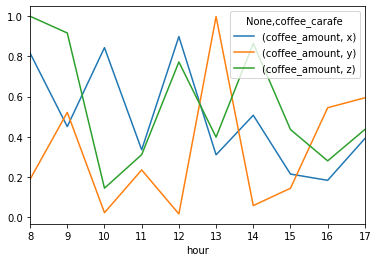

In [18]:
new_df.plot()

#### To answer the question, it does look like this is the best shape of the data, as each of the coffee carafes seem to be pretty evenly distributed around hours 12 and 13.

### Q3: Cake Recipes

Read the cake_recipes.csv data. This data set contains cake tastiness scores for combinations of different recipes, oven rack positions, and oven temperatures.

- Tidy the data as necessary.
- Which recipe, on average, is the best? recipe b
- Which oven temperature, on average, produces the best results? 275
- Which combination of recipe, rack position, and temperature gives the best result? recipe b, bottom rack, 300 degrees

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("cake_recipes.csv")
df.head()

,recipe:position,225,250,275,300
0,a:bottom,61.738655,53.912627,74.414730,98.786784
1,a:top,51.709751,52.009735,68.576858,50.228470
2,b:bottom,57.095320,61.904369,61.196980,99.248541
3,b:top,82.455004,95.224151,98.594881,58.169349
4,c:bottom,96.470207,52.001358,92.893227,65.473084


#### Ew.  Look at all that mess.  Nearly unreadable.  

- melting

In [2]:
df = df.melt(id_vars="recipe:position", var_name="temp", value_name="cake_score")
print(df)

   recipe:position temp  cake_score
0         a:bottom  225   61.738655
1            a:top  225   51.709751
2         b:bottom  225   57.095320
3            b:top  225   82.455004
4         c:bottom  225   96.470207
5            c:top  225   71.306308
6         d:bottom  225   52.799753
7            d:top  225   96.873178
8         a:bottom  250   53.912627
9            a:top  250   52.009735
10        b:bottom  250   61.904369
11           b:top  250   95.224151
12        c:bottom  250   52.001358
13           c:top  250   82.795477
14        d:bottom  250   58.670419
15           d:top  250   76.101363
16        a:bottom  275   74.414730
17           a:top  275   68.576858
18        b:bottom  275   61.196980
19           b:top  275   98.594881
20        c:bottom  275   92.893227
21           c:top  275   92.098049
22        d:bottom  275   51.747686
23           d:top  275   59.571620
24        a:bottom  300   98.786784
25           a:top  300   50.228470
26        b:bottom  300   99

In [3]:
recipe_position = df["recipe:position"].str.split(":", expand=True)
recipe_position

,0,1
0,a,bottom
1,a,top
2,b,bottom
3,b,top
4,c,bottom
5,c,top
6,d,bottom
7,d,top
8,a,bottom
9,a,top


In [4]:
recipe_position.columns = ["recipe", "position"]
recipe_position

,recipe,position
0,a,bottom
1,a,top
2,b,bottom
3,b,top
4,c,bottom
5,c,top
6,d,bottom
7,d,top
8,a,bottom
9,a,top


In [5]:
df = pd.concat([df, recipe_position], axis=1).drop(columns="recipe:position")
df

,temp,cake_score,recipe,position
0,225,61.738655,a,bottom
1,225,51.709751,a,top
2,225,57.095320,b,bottom
3,225,82.455004,b,top
4,225,96.470207,c,bottom
5,225,71.306308,c,top
6,225,52.799753,d,bottom
7,225,96.873178,d,top
8,250,53.912627,a,bottom
9,250,52.009735,a,top


#### Which recipe, on average, is the best?

In [7]:
df.groupby("recipe").cake_score.mean()

recipe
a    63.922201
b    76.736074
c    75.874748
d    62.864844
Name: cake_score, dtype: float64

#### Which oven temperature, on average, produces the best results?

In [8]:
df.groupby("temp").mean()

,cake_score
temp,
225,71.306022
250,66.577437
275,74.886754
300,66.627655


In [9]:
df.groupby("temp").cake_score.mean()

temp
225    71.306022
250    66.577437
275    74.886754
300    66.627655
Name: cake_score, dtype: float64

#### Proof 275 is the best temp by .nlargest(1):

In [10]:
df.groupby("temp").cake_score.mean().nlargest(1)

temp
275    74.886754
Name: cake_score, dtype: float64

In [11]:
df.groupby("temp").cake_score.mean().sort_values().tail(1).index

Index(['275'], dtype='object', name='temp')

#### Which combination of recipe, rack position, and temperature gives the best result?

In [12]:
df.groupby(["recipe", "position", "temp"]).cake_score.mean().nlargest(1)

recipe  position  temp
b       bottom    300     99.248541
Name: cake_score, dtype: float64